In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_percentage_error
import torch.optim as optim
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime

In [ ]:
import os
import random
import sklearn

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    tf.random.set_seed(seed)


# seed_everything(0xAAAAAAA)
seed_everything(12345)

In [ ]:
stock_data = yf.download('googl', start='2017-01-01', end='2019-12-31')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000
2017-01-04,40.494499,40.671501,40.205502,40.388500,40.388500,30306000
2017-01-05,40.375000,40.687000,40.296001,40.651001,40.651001,26810000
2017-01-06,40.749500,41.448002,40.575001,41.260502,41.260502,40342000
2017-01-09,41.318501,41.521500,41.081001,41.359001,41.359001,28178000


Text(0, 0.5, 'Prices ($)')

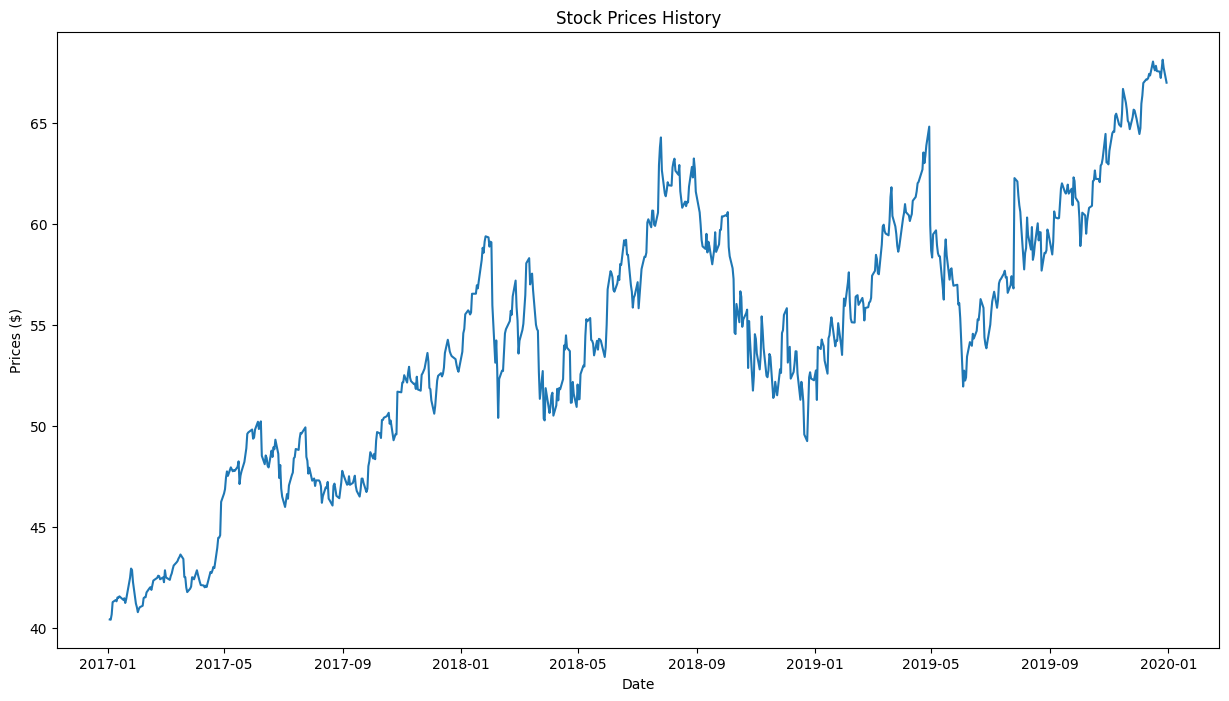

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

# нормализация
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

---------------------------------------------------------------

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=False, input_shape=(x_train.shape[1], 1)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 100)               40800     
                                                                 
 dense_26 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=15)

Epoch 1/15
543/543 [==============================] - 4s 4ms/step - loss: 0.0051
Epoch 2/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0024
Epoch 3/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0019
Epoch 4/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0016
Epoch 5/15
543/543 [==============================] - 3s 6ms/step - loss: 0.0014
Epoch 6/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 7/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 8/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0012
Epoch 9/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 10/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0012
Epoch 11/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0011
Epoch 12/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0012
Epoch 13/15
543/543 [====

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5/5 [==============================] - 0s 4ms/step


0.5885477193196614

In [ ]:
mape = mean_absolute_percentage_error(y_test, predictions)
mape

0.012798374602951714

In [ ]:
r2_score = sklearn.metrics.r2_score(y_test, predictions)
r2_score

0.9398692491455137

<ipython-input-545-8940a43030e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


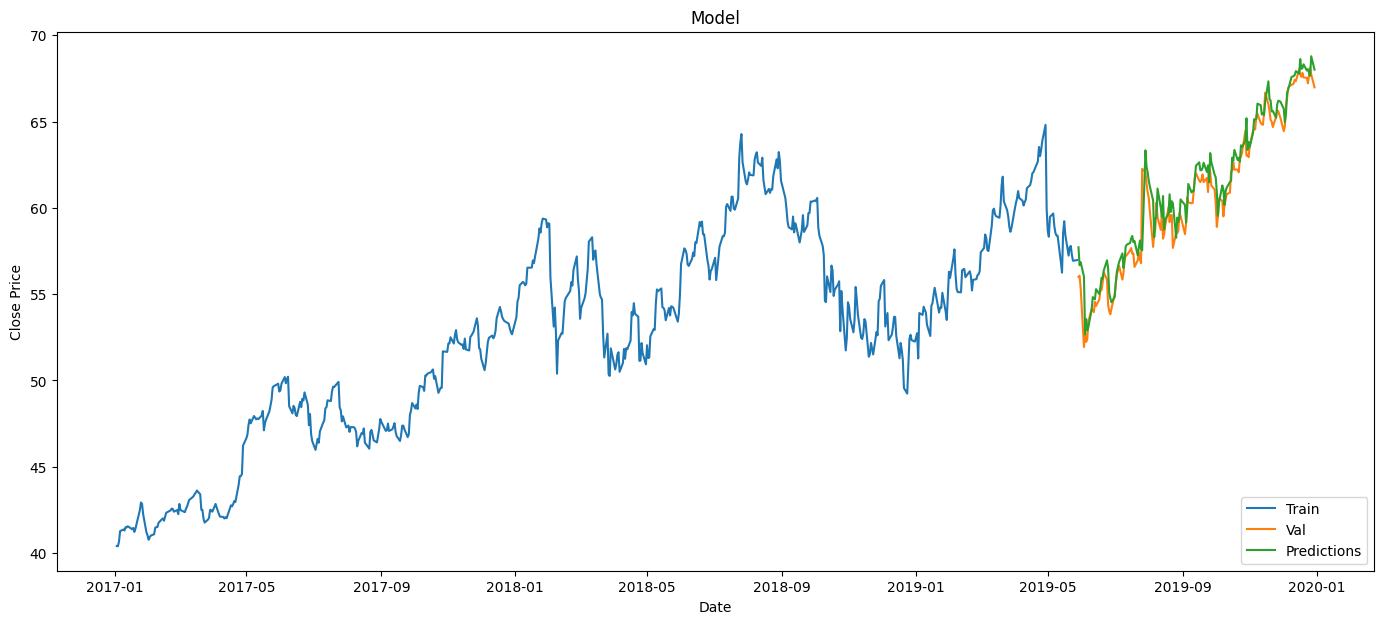

In [ ]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(17,7))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

---------------------------------------------------------------------------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Качается датасет, с помощью vader'а делается поляризация новостей, где -1 negative, +1 positive.

In [ ]:
news_df = pd.read_csv("/content/gdrive/MyDrive/project/Tweet.csv")

In [ ]:
news_df

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
...,...,...,...,...,...,...,...
3717959,1212159765914079234,TEEELAZER,1577836383,That $SPY $SPX puuump in the last hour was the...,1,0,6
3717960,1212159838882533376,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1
3717961,1212160015332728833,Commuternyc,1577836443,Patiently Waiting for the no twitter sitter tw...,0,0,5
3717962,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1


In [ ]:
company_df = pd.read_csv("/content/gdrive/MyDrive/project/Company_Tweet.csv")

In [ ]:
company_df

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL
...,...,...
4336440,1212158772015034369,TSLA
4336441,1212159099632267268,TSLA
4336442,1212159184931717120,TSLA
4336443,1212159838882533376,TSLA


In [ ]:
tweet_df = pd.merge(company_df, news_df, on="tweet_id", how= "inner")

In [ ]:
tweet_df

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
...,...,...,...,...,...,...,...,...
4336440,1212158772015034369,TSLA,StockJoke,1577836146,"I'm getting wasted on NYE, and thanks to @NHTS...",0,0,0
4336441,1212159099632267268,TSLA,sweetog76,1577836224,$TSLA Very Interesting dude:,0,0,0
4336442,1212159184931717120,TSLA,MelaynaLokosky,1577836245,If only 2020 brought more self-awareness to Te...,0,1,0
4336443,1212159838882533376,TSLA,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1


In [ ]:
tweet_df = tweet_df[(tweet_df['ticker_symbol'] == 'GOOG') | (tweet_df['ticker_symbol'] == 'GOOGL')]

In [ ]:
tweet_df

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
17,550795088821886976,GOOGL,MarkDePompeo,1420154757,"""@CNBC: This is Wall Street's top pick in 2015...",0,0,0
44,550780769497808896,GOOG,SharePlanner,1420151343,2014 Was A Great Year of Trading In The Splash...,1,0,1
62,550771969789267968,GOOG,GiveBack2011,1420149245,@BenedictEvans Great one. $GOOG at risk from $...,1,0,0
70,550759232455585792,GOOGL,CloudChipotle,1420146208,"@downsidecapital $FB can't afford it, so $GOOG...",1,0,1
...,...,...,...,...,...,...,...,...
2541282,1212117616271056898,GOOGL,pbay08,1577826334,$hd Perfect 20sma touch and run. This is going...,0,0,1
2541285,1212142968037138432,GOOGL,faang_gang,1577832378,$GOOGL also flat today,1,0,0
2541286,1212149780471853057,GOOGL,harveyrosenblum,1577834002,If this continues then the market will be enti...,0,0,2
2541288,1212150864066023427,GOOGL,Flower_Power_67,1577834261,#FastMoneyEspressoFINAL TRADES:Steve Grasso —>...,0,1,4


In [ ]:
tweet_df['post_date'] = pd.to_datetime(tweet_df['post_date'], unit='s')

<ipython-input-21-449982cc9dd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['post_date'] = pd.to_datetime(tweet_df['post_date'], unit='s')


In [ ]:
tweet_df['day_date'] = pd.to_datetime(tweet_df['post_date'].apply(lambda date: date.date()))

<ipython-input-23-6003252feedb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['day_date'] = pd.to_datetime(tweet_df['post_date'].apply(lambda date: date.date()))


In [ ]:
tweet_df

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,day_date
3,550803610825928706,GOOGL,SentiQuant,2015-01-01 23:59:48,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01
17,550795088821886976,GOOGL,MarkDePompeo,2015-01-01 23:25:57,"""@CNBC: This is Wall Street's top pick in 2015...",0,0,0,2015-01-01
44,550780769497808896,GOOG,SharePlanner,2015-01-01 22:29:03,2014 Was A Great Year of Trading In The Splash...,1,0,1,2015-01-01
62,550771969789267968,GOOG,GiveBack2011,2015-01-01 21:54:05,@BenedictEvans Great one. $GOOG at risk from $...,1,0,0,2015-01-01
70,550759232455585792,GOOGL,CloudChipotle,2015-01-01 21:03:28,"@downsidecapital $FB can't afford it, so $GOOG...",1,0,1,2015-01-01
...,...,...,...,...,...,...,...,...,...
2541282,1212117616271056898,GOOGL,pbay08,2019-12-31 21:05:34,$hd Perfect 20sma touch and run. This is going...,0,0,1,2019-12-31
2541285,1212142968037138432,GOOGL,faang_gang,2019-12-31 22:46:18,$GOOGL also flat today,1,0,0,2019-12-31
2541286,1212149780471853057,GOOGL,harveyrosenblum,2019-12-31 23:13:22,If this continues then the market will be enti...,0,0,2,2019-12-31
2541288,1212150864066023427,GOOGL,Flower_Power_67,2019-12-31 23:17:41,#FastMoneyEspressoFINAL TRADES:Steve Grasso —>...,0,1,4,2019-12-31


In [ ]:
tweet_df = tweet_df.sort_values(by="day_date")

In [ ]:
tweet_df = tweet_df.drop(['tweet_id', 'post_date', 'comment_num', 'retweet_num', 'like_num'], axis=1)

In [ ]:
tweet_df = tweet_df[(tweet_df['day_date'] >= '2017-01-01')]

In [ ]:
tweet_df

,ticker_symbol,writer,body,day_date
2097990,GOOG,It_c0nsulting,#Google Responds To Nexus 6P Users About The E...,2017-01-01
2098021,GOOG,It_c0nsulting,"LG to Supply Apple, #Google and Samsung with F...",2017-01-01
2098022,GOOG,It_c0nsulting,"The crazy, eccentric, successful life of #Goog...",2017-01-01
2098023,GOOG,It_c0nsulting,Adding an OnHub router to your #Google Wifi ne...,2017-01-01
2098024,GOOG,It_c0nsulting,Now #Google can help you find a toilet in Indi...,2017-01-01
...,...,...,...,...
2258230,GOOG,econalert,"$GOOG #patent 10,523,916 Modifying images with...",2019-12-31
2258229,GOOG,ThalesofM,$GOOG #Google,2019-12-31
2258228,GOOG,econalert,"$GOOG #patent 10,524,266 Switching transmissio...",2019-12-31
2258236,GOOG,SVPR_Sweetheart,I'm banking on this and that Google will still...,2019-12-31


In [ ]:
tweet_df.to_csv(r'/content/gdrive/MyDrive/project/tweet_df.csv')

In [ ]:
tweet_df = pd.read_csv("/content/gdrive/MyDrive/project/tweet_df.csv")

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
analyzer = SentimentIntensityAnalyzer()
tweet_df['Compound'] = tweet_df['body'].apply(lambda content: analyzer.polarity_scores(content)['compound'])
tweet_df['Polarity'] = tweet_df['Compound'].apply(lambda c: 1 if c >=0 else -1)
tweet_df.head()            

<ipython-input-45-20529d01dc52>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['Compound'] = tweet_df['body'].apply(lambda content: analyzer.polarity_scores(content)['compound'])
<ipython-input-45-20529d01dc52>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['Polarity'] = tweet_df['Compound'].apply(lambda c: 1 if c >=0 else -1)


,ticker_symbol,writer,body,day_date,Compound,Polarity
2097990,GOOG,It_c0nsulting,#Google Responds To Nexus 6P Users About The E...,2017-01-01,0.0000,1
2098021,GOOG,It_c0nsulting,"LG to Supply Apple, #Google and Samsung with F...",2017-01-01,0.0000,1
2098022,GOOG,It_c0nsulting,"The crazy, eccentric, successful life of #Goog...",2017-01-01,0.3400,1
2098023,GOOG,It_c0nsulting,Adding an OnHub router to your #Google Wifi ne...,2017-01-01,0.0000,1
2098024,GOOG,It_c0nsulting,Now #Google can help you find a toilet in Indi...,2017-01-01,0.4019,1


In [ ]:
print(stock_data.loc["2017-01-03"]["Open"])
stock_data['Polarity'] = 0
stock_data['sum'] = 0

40.03099822998047


In [ ]:
dates = pd.DataFrame(stock_data.index)

In [ ]:
dates['Date'] = dates['Date'].apply(lambda date: date.date())

In [ ]:
tweet_df['day_date'] = tweet_df['day_date'].apply(lambda data: datetime.datetime(2000, 1, 1) if (dates['Date']==data.date()).any() == False else data)

<ipython-input-51-2a69114518e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df["day_date"] = tweet_df["day_date"].apply(lambda data: datetime.datetime(2000, 1, 1) if (dates['Date']==data.date()).any() == False else data)


In [ ]:
pol_df = pd.DataFrame()
pol_df['Date'] = tweet_df['day_date']
pol_df['Polarity'] = tweet_df['Polarity']
pol_df = pol_df[(pol_df['Date'] >= '2017-01-01')]
pol_df

,Date,Polarity
927400,2017-01-03,1
2098335,2017-01-03,1
2098336,2017-01-03,1
2098337,2017-01-03,1
2098334,2017-01-03,1
...,...,...
2258013,2019-12-30,1
2258016,2019-12-30,1
2258019,2019-12-30,1
2258020,2019-12-30,1


In [ ]:
for index, row in pol_df.iterrows():
    # print(row["Polarity"])
    stock_data.at[str(row["Date"].date()), "Polarity"] += row["Polarity"] 
    stock_data.at[str(row["Date"].date()), "sum"] += 1
    # print(stock_data.loc[str(row["Date"].date())]["Polarity"], row["Date"])

stock_data

Выходные данные были обрезаны до нескольких последних строк (5000).
-1
13.0 2019-12-16 00:00:00
1
14.0 2019-12-16 00:00:00
-1
13.0 2019-12-16 00:00:00
-1
12.0 2019-12-16 00:00:00
1
13.0 2019-12-16 00:00:00
-1
12.0 2019-12-16 00:00:00
1
13.0 2019-12-16 00:00:00
-1
12.0 2019-12-16 00:00:00
1
13.0 2019-12-16 00:00:00
1
14.0 2019-12-16 00:00:00
1
15.0 2019-12-16 00:00:00
1
16.0 2019-12-16 00:00:00
1
17.0 2019-12-16 00:00:00
1
18.0 2019-12-16 00:00:00
1
19.0 2019-12-16 00:00:00
1
20.0 2019-12-16 00:00:00
1
21.0 2019-12-16 00:00:00
1
22.0 2019-12-16 00:00:00
1
23.0 2019-12-16 00:00:00
1
24.0 2019-12-16 00:00:00
1
25.0 2019-12-16 00:00:00
-1
24.0 2019-12-16 00:00:00
1
25.0 2019-12-16 00:00:00
-1
24.0 2019-12-16 00:00:00
1
25.0 2019-12-16 00:00:00
1
26.0 2019-12-16 00:00:00
1
27.0 2019-12-16 00:00:00
1
28.0 2019-12-16 00:00:00
1
29.0 2019-12-16 00:00:00
1
30.0 2019-12-16 00:00:00
1
31.0 2019-12-16 00:00:00
1
32.0 2019-12-16 00:00:00
1
33.0 2019-12-16 00:00:00
1
34.0 2019-12-16 00:00:00
-1
33.0

,Open,High,Low,Close,Adj Close,Volume,Polarity,sum
Date,,,,,,,,
2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000,309,393
2017-01-04,40.494499,40.671501,40.205502,40.388500,40.388500,30306000,359,455
2017-01-05,40.375000,40.687000,40.296001,40.651001,40.651001,26810000,490,648
2017-01-06,40.749500,41.448002,40.575001,41.260502,41.260502,40342000,415,509
2017-01-09,41.318501,41.521500,41.081001,41.359001,41.359001,28178000,411,517
...,...,...,...,...,...,...,...,...
2019-12-23,67.936501,68.092499,67.400002,67.531502,67.531502,19936000,116,180
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.221497,13468000,144,196
2019-12-26,67.327499,68.160004,67.275497,68.123497,68.123497,23662000,223,287


In [ ]:
stock_data.to_csv(r'/content/gdrive/MyDrive/project/stock_vader.csv')

In [ ]:
stock_data = pd.read_csv("/content/gdrive/MyDrive/project/stock_vader.csv", index_col=0)

In [ ]:
stock_data["Polarity"].unique()

array([ 309,  359,  490,  415,  411,  370,  340,  356,  308,  346,  498,
        332,  279,  554,  491,  414,  926,  772,  410,  342,  363,  393,
        464,  337,  303,  399,  379,  468,  313,  172,  224,  199,  163,
        198,  181,  161,  210,  294,  251,  190,  201,  182,  177,  296,
        245,  203,  160,  157,  225,  166,  188,  178,  254,  243,  194,
        209,  261,  195,  215,  229,  222,  226,  159,  154,  158,  204,
        216,  155,  202,  167,  344,  299,  786,  594,  317,  278,  265,
        223,  239,  152,  186,  269,  218,  329,  234,  467,  300,  284,
        277,  276,  293,  281,  205,  422,  257,  187,  214,  366,  581,
        384,  324,  302,  253,  263,  295,  213,  271,  241,  272,  922,
        812,  418,  441,  305,  171,  208,  252,  268,  264,  168,  248,
        242,  192,  207,  250,  301,   88,  273,  247,  146,  211,  345,
        256,  369,  409,  280,  425,  274,  292,  331,  466,  413,  315,
        357,  290,  447,  323,  287,  230,  285,  4

In [ ]:
stock_data["sum"].unique()

array([ 393,  455,  648,  509,  517,  518,  472,  542,  442,  466,  662,
        478,  373,  714,  669,  638, 1420, 1250,  738,  654,  551,  613,
        602,  703,  495,  525,  493,  460,  616,  409,  256,  290,  263,
        239,  252,  231,  258,  374,  339,  304,  259,  278,  299,  394,
        325,  267,  246,  295,  270,  288,  383,  255,  454,  377,  322,
        305,  353,  248,  265,  365,  358,  310,  271,  262,  220,  207,
        274,  284,  407,  468,  411, 1018,  401,  406,  352,  371,  313,
        351,  232,  338,  326,  419,  328,  308,  461,  344,  637,  444,
        418,  436,  356,  565,  397,  269,  606,  470,  441,  330,  467,
        367,  283,  296,  480,  909,  526,  532,  323,  424,  324,  396,
        285,  321,  375,  307,  279,  334, 1272, 1208,  550,  581,  332,
        348,  524,  416,  435,  399,  389,  370,  282,  257,  342,  405,
        430,  272,  354,  331,  300,  280,  266,  204,  315,  427,  388,
        449,  479,  523,  286,  390,  380,  543,  3

In [ ]:
stock_data["sum"] = stock_data["sum"].apply(lambda x: 1 if x == 0 else x)

In [ ]:
stock_data["Polarity"] = stock_data["Polarity"] / stock_data["sum"]

In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Polarity,sum
Date,,,,,,,,
2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000,0.786260,393
2017-01-04,40.494499,40.671501,40.205502,40.388500,40.388500,30306000,0.789011,455
2017-01-05,40.375000,40.687000,40.296001,40.651001,40.651001,26810000,0.756173,648
2017-01-06,40.749500,41.448002,40.575001,41.260502,41.260502,40342000,0.815324,509
2017-01-09,41.318501,41.521500,41.081001,41.359001,41.359001,28178000,0.794971,517
...,...,...,...,...,...,...,...,...
2019-12-23,67.936501,68.092499,67.400002,67.531502,67.531502,19936000,0.644444,180
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.221497,13468000,0.734694,196
2019-12-26,67.327499,68.160004,67.275497,68.123497,68.123497,23662000,0.777003,287


-------------------------------------------------------
Новое обучение с новостями

In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Polarity,sum
Date,,,,,,,,
2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000,0.786260,393
2017-01-04,40.494499,40.671501,40.205502,40.388500,40.388500,30306000,0.789011,455
2017-01-05,40.375000,40.687000,40.296001,40.651001,40.651001,26810000,0.756173,648
2017-01-06,40.749500,41.448002,40.575001,41.260502,41.260502,40342000,0.815324,509
2017-01-09,41.318501,41.521500,41.081001,41.359001,41.359001,28178000,0.794971,517
...,...,...,...,...,...,...,...,...
2019-12-23,67.936501,68.092499,67.400002,67.531502,67.531502,19936000,0.644444,180
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.221497,13468000,0.734694,196
2019-12-26,67.327499,68.160004,67.275497,68.123497,68.123497,23662000,0.777003,287


In [ ]:
close_prices = stock_data["Close"]
polarity = stock_data["Polarity"]
polarity = polarity.values.reshape(-1,1)

values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)
# нормализация
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

scaled_data = np.hstack([scaled_data, polarity])

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 0])
    

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

In [ ]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=False, input_shape=(x_train.shape[1], 2)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 100)               41200     
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=15)

Epoch 1/15
543/543 [==============================] - 4s 4ms/step - loss: 0.0100
Epoch 2/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0029
Epoch 3/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0023
Epoch 4/15
543/543 [==============================] - 3s 6ms/step - loss: 0.0019
Epoch 5/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0016
Epoch 6/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0015
Epoch 7/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0015
Epoch 8/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0014
Epoch 9/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0014
Epoch 10/15
543/543 [==============================] - 3s 6ms/step - loss: 0.0013
Epoch 11/15
543/543 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 12/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0012
Epoch 13/15
543/543 [====

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5/5 [==============================] - 0s 3ms/step


1.0211472829182944

In [ ]:
mape = mean_absolute_percentage_error(y_test, predictions)
mape

0.018368502973139432

In [ ]:
r2_score = sklearn.metrics.r2_score(y_test, predictions)
r2_score

0.8987369186998503

<ipython-input-588-8940a43030e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


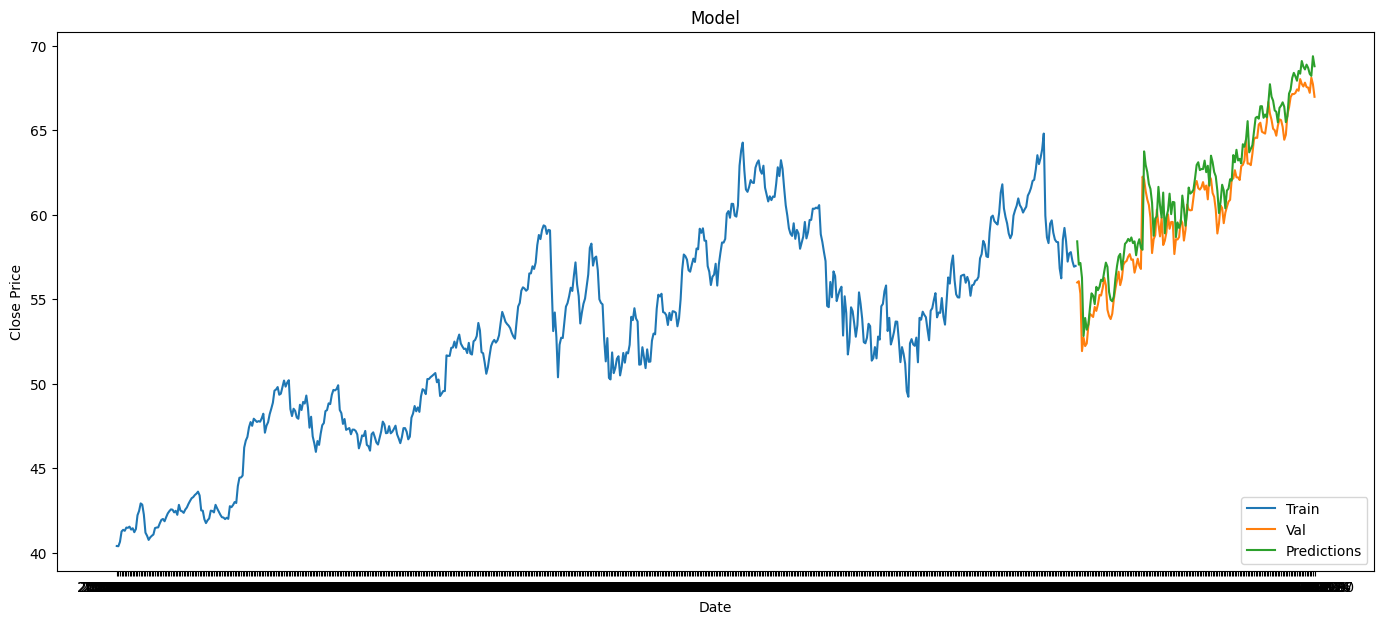

In [ ]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(17,7))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

-------------------------------------------------------------

Обучение с рандомными значениями полярности

In [ ]:
stock_data = pd.read_csv("/content/gdrive/MyDrive/project/stock_vader.csv", index_col=0)

In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Polarity,sum
Date,,,,,,,,
2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000,309,393
2017-01-04,40.494499,40.671501,40.205502,40.388500,40.388500,30306000,359,455
2017-01-05,40.375000,40.687000,40.296001,40.651001,40.651001,26810000,490,648
2017-01-06,40.749500,41.448002,40.575001,41.260502,41.260502,40342000,415,509
2017-01-09,41.318501,41.521500,41.081001,41.359001,41.359001,28178000,411,517
...,...,...,...,...,...,...,...,...
2019-12-23,67.936501,68.092499,67.400002,67.531502,67.531502,19936000,116,180
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.221497,13468000,144,196
2019-12-26,67.327499,68.160004,67.275497,68.123497,68.123497,23662000,223,287


In [ ]:
stock_data["Polarity"] = stock_data["Polarity"].apply(lambda x: np.random.random() * 2 - 1)

In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Polarity,sum
Date,,,,,,,,
2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000,0.867519,393
2017-01-04,40.494499,40.671501,40.205502,40.388500,40.388500,30306000,-0.738537,455
2017-01-05,40.375000,40.687000,40.296001,40.651001,40.651001,26810000,0.345804,648
2017-01-06,40.749500,41.448002,40.575001,41.260502,41.260502,40342000,0.483252,509
2017-01-09,41.318501,41.521500,41.081001,41.359001,41.359001,28178000,0.531329,517
...,...,...,...,...,...,...,...,...
2019-12-23,67.936501,68.092499,67.400002,67.531502,67.531502,19936000,-0.176147,180
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.221497,13468000,0.835654,196
2019-12-26,67.327499,68.160004,67.275497,68.123497,68.123497,23662000,-0.498343,287


In [ ]:
close_prices = stock_data["Close"]
polarity = stock_data["Polarity"]
polarity = polarity.values.reshape(-1,1)

values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)
# нормализация
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

scaled_data = np.hstack([scaled_data, polarity])

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 0])
    

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

In [ ]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=False, input_shape=(x_train.shape[1], 2)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 100)               41200     
                                                                 
 dense_36 (Dense)            (None, 1)                 101       
                                                                 
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=15)

Epoch 1/15
543/543 [==============================] - 4s 5ms/step - loss: 0.0079
Epoch 2/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0031
Epoch 3/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0024
Epoch 4/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 5/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0018
Epoch 6/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0016
Epoch 7/15
543/543 [==============================] - 3s 6ms/step - loss: 0.0015
Epoch 8/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0014
Epoch 9/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0016
Epoch 10/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0014
Epoch 11/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 12/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0012
Epoch 13/15
543/543 [====

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5/5 [==============================] - 0s 3ms/step


1.0411400604248047

In [ ]:
mape = mean_absolute_percentage_error(y_test, predictions)
mape

0.01872601636432391

In [ ]:
r2_score = sklearn.metrics.r2_score(y_test, predictions)
r2_score

0.8945517676282226

<ipython-input-600-8940a43030e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


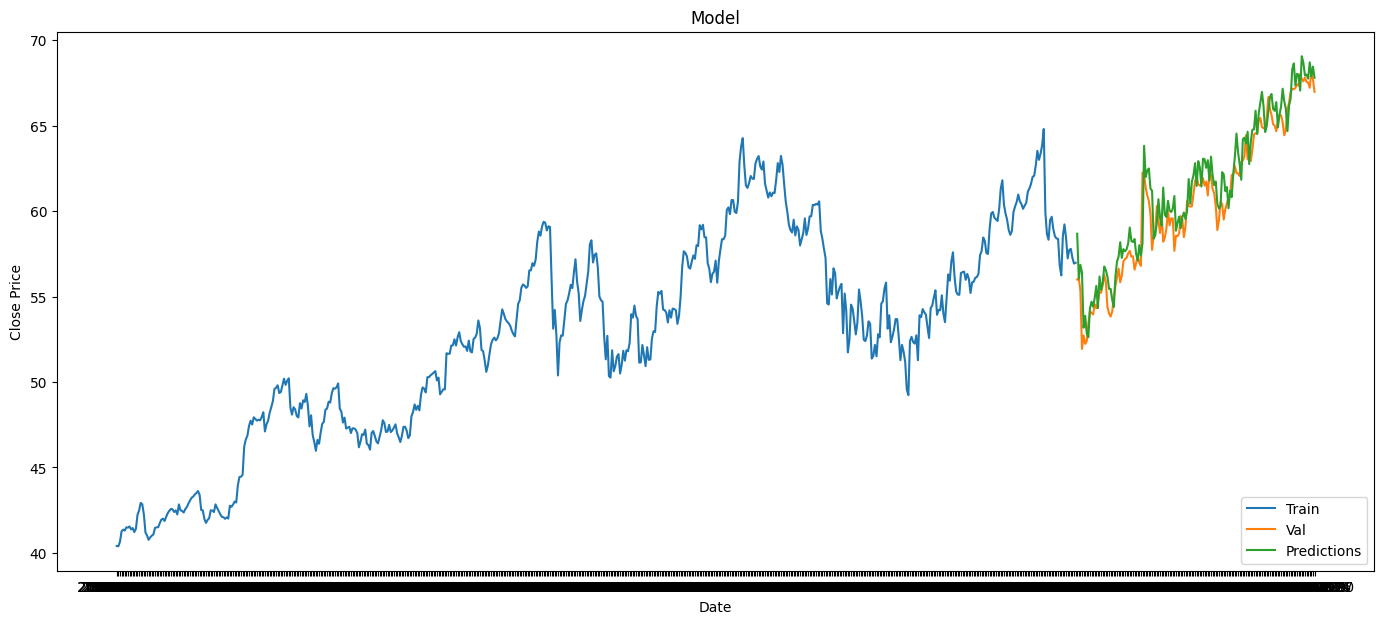

In [ ]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(17,7))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
This is a roBERTa-base model trained on ~58M tweets and finetuned for sentiment analysis 

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 25.9 MB/s eta 0:00:00


In [ ]:
import transformers
from transformers import pipeline

-------------------------------------------------------

In [ ]:
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

-------------------------------------------------------

In [ ]:
from tqdm import tqdm

In [ ]:
tweet_df = pd.read_csv("/content/gdrive/MyDrive/project/tweet_df.csv")

In [ ]:
results = pd.DataFrame(columns=['hid_state', 'logits'], index=range(tweet_df.shape[0]))

In [ ]:
# results = pd.read_csv("/content/gdrive/MyDrive/project/results.csv")

In [ ]:
task='sentiment'
MODELtxt = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODELtxt)
model0 = AutoModelForSequenceClassification.from_pretrained(MODELtxt, output_hidden_states=True).to('cuda:0')

In [ ]:
for i in tqdm(range(0, len(tweet_df))):

    inputs = tokenizer(preprocess(tweet_df.iloc[i]['body']), return_tensors="pt").to("cuda:0")

    outputs = model0(**inputs)
    print(i)
    results.iloc[i]['hid_state'] = torch.mean(outputs['hidden_states'][-1], dim=1).cpu().detach() 
    results.iloc[i]['logits'] = outputs['logits'][-1].cpu().detach() 

In [ ]:
# results = pd.read_csv("/content/gdrive/MyDrive/project/results.csv")

In [ ]:
tweet_df['Polarity'] = 0

In [ ]:
from scipy.special import softmax

In [ ]:
import urllib
import csv

In [ ]:
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [ ]:
labels

['negative', 'neutral', 'positive']

In [ ]:
labels = [-1, 0, 1]

In [ ]:
results = results.set_index(pd.Index(range(0, 338258)))

In [ ]:
tweet_df['Polarity'] = results['logits'].apply(lambda x: labels[np.argsort(x.numpy())[::-1][0]])

In [ ]:
tweet_df

,Unnamed: 0,ticker_symbol,writer,body,day_date,Polarity
0,2097990,GOOG,It_c0nsulting,#Google Responds To Nexus 6P Users About The E...,2017-01-01,0
5,2098025,GOOG,It_c0nsulting,#Google Home interrupts music playback without...,2017-01-01,0
10,2098030,GOOG,It_c0nsulting,Imec Collaborates with #Google to Offer Cloud ...,2017-01-01,1
15,2098035,GOOG,It_c0nsulting,#Google Nexus 6P bootloop problems follow 5X's...,2017-01-01,-1
20,2098040,GOOG,It_c0nsulting,#Google Top Business Stories of 2016 No. 6: T...,2017-01-01,0
...,...,...,...,...,...,...
338235,2258202,GOOG,InvincibleBull,It’s not $GME going to start off 2020 with a m...,2019-12-31,0
338240,1863837,GOOGL,NishantGogna,My picks for 2020! Bullish: $SPCE $AMZN $GOOGL...,2019-12-31,0
338245,2541288,GOOGL,Flower_Power_67,#FastMoneyEspressoFINAL TRADES:Steve Grasso —>...,2019-12-31,0
338250,2258233,GOOG,tq_equities,$GOOG closes within prior day's range after la...,2019-12-31,1


-------------------------------------------------------

In [ ]:
tweet_df.to_csv(r'/content/gdrive/MyDrive/project/tweet_fin_roberta_pol0.csv')

In [ ]:
tweet_df = pd.read_csv("/content/gdrive/MyDrive/project/tweet_fin_roberta_pol0.csv")

---------------------------------------------------------------------------

In [ ]:
dates = pd.DataFrame(stock_data.index)

In [ ]:
dates['Date'] = dates['Date'].apply(lambda date: date.date())

In [ ]:
from datetime import datetime

In [ ]:
tweet_df['day_date'] = tweet_df['day_date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d').date())

In [ ]:
tweet_df['day_date'] = tweet_df['day_date'].apply(lambda data: datetime(2000, 1, 1) if (dates['Date']==data).any() == False else data)

/usr/local/lib/python3.9/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [ ]:
pol_df = pd.DataFrame()
pol_df['Date'] = tweet_df['day_date']
pol_df['Polarity'] = tweet_df['Polarity']
pol_df = pol_df[(pol_df['Date'] >= '2017-01-01')]
pol_df

,Date,Polarity
80,2017-01-03,0
81,2017-01-03,1
82,2017-01-03,1
83,2017-01-03,0
84,2017-01-03,1
...,...,...
67600,2019-12-30,1
67601,2019-12-30,0
67602,2019-12-30,1
67603,2019-12-30,0


In [ ]:
stock_data['Polarity'] = 0
stock_data['sum'] = 0

In [ ]:
for index, row in pol_df.iterrows():
    # print(row["Polarity"])
    stock_data.at[str(row["Date"].date()), "Polarity"] += row["Polarity"] 
    stock_data.at[str(row["Date"].date()), "sum"] += 1
    # print(stock_data.loc[str(row["Date"].date())]["Polarity"], row["Date"])

stock_data

In [ ]:
# stock_data = pd.read_csv("/content/gdrive/MyDrive/project/fin_roberta_stock_data0.csv")

In [ ]:
stock_data["Polarity"].unique()

array([ 35,  36,  62,  45,  41,  33,  49,  37,  57,  68,  50,  63,  82,
        58,  39,  24,  31,  48,  44,  43,  51,  65,  11,  18,  16,  14,
        20,  21,  26,   9,  12,  22,  10,  25,   4,   1,  17,  15,  19,
         7,   8,  74,  64,  27,  29,  13,  23,  42,  -2,  54,  73,  -1,
        30,   2,  38,  87,  90,  28,  32,   6,  40,   5,  52, -14, 111,
        88,  -5,   3,  -9,  47,  55,  69,  60])

In [ ]:
stock_data["sum"].unique()

array([ 78,  91, 130, 102, 104, 103,  95, 108,  88,  94, 132,  96,  74,
       143, 134, 127, 284, 250, 148, 131, 110, 122, 121, 141,  99, 105,
        98,  92, 123,  82,  51,  58,  53,  47,  46,  75,  68,  61,  56,
        60,  65,  54,  49,  48,  59,  77,  70,  50,  73,  72,  64,  62,
        52,  44,  42,  55,  57,  93, 204,  80,  63,  67,  84,  69,  89,
        87,  71, 113,  79,  66, 182, 106, 254, 242, 116,  83,  81,  86,
        41,  90,  76, 109, 112,  85, 193, 219, 100,  43, 198, 138, 114,
       137, 136, 107, 244, 139, 129,  45, 115, 261, 255, 135, 117, 111,
       206, 180,  38, 101,  37, 271, 225, 146, 289, 320, 234, 128,  39,
       209,  34, 151,  23,  40,  36])

In [ ]:
stock_data["sum"] = stock_data["sum"].apply(lambda x: 1 if x == 0 else x)

In [ ]:
stock_data["Polarity"] = stock_data["Polarity"] / stock_data["sum"]

In [ ]:
stock_data.to_csv(r'/content/gdrive/MyDrive/project/fin_roberta_stock_data0.csv')

In [ ]:
stock_data = pd.read_csv("/content/gdrive/MyDrive/project/fin_roberta_stock_data0.csv", index_col=0)

-------------------------------------------------------
Новое обучение с новостями

In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Polarity,sum
Date,,,,,,,,
2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000,0.448718,78
2017-01-04,40.494499,40.671501,40.205502,40.388500,40.388500,30306000,0.395604,91
2017-01-05,40.375000,40.687000,40.296001,40.651001,40.651001,26810000,0.476923,130
2017-01-06,40.749500,41.448002,40.575001,41.260502,41.260502,40342000,0.441176,102
2017-01-09,41.318501,41.521500,41.081001,41.359001,41.359001,28178000,0.394231,104
...,...,...,...,...,...,...,...,...
2019-12-23,67.936501,68.092499,67.400002,67.531502,67.531502,19936000,0.361111,36
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.221497,13468000,0.225000,40
2019-12-26,67.327499,68.160004,67.275497,68.123497,68.123497,23662000,0.070175,57


In [ ]:
close_prices = stock_data["Close"]
polarity = stock_data["Polarity"]
polarity = polarity.values.reshape(-1,1)

values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)
# нормализация
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

scaled_data = np.hstack([scaled_data, polarity])

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 0])
    

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

In [ ]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=False, input_shape=(x_train.shape[1], 2)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 100)               41200     
                                                                 
 dense_41 (Dense)            (None, 1)                 101       
                                                                 
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=15)

Epoch 1/15
543/543 [==============================] - 4s 4ms/step - loss: 0.0067
Epoch 2/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0024
Epoch 3/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0020
Epoch 4/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0018
Epoch 5/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0014
Epoch 6/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0014
Epoch 7/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0014
Epoch 8/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 9/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0013
Epoch 10/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0013
Epoch 11/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 12/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0012
Epoch 13/15
543/543 [====

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5/5 [==============================] - 0s 3ms/step


1.0571995290120442

In [ ]:
mape = mean_absolute_percentage_error(y_test, predictions)
mape

0.01882605762859102

In [ ]:
r2_score = sklearn.metrics.r2_score(y_test, predictions)
r2_score

0.8942662123868249

<ipython-input-665-8940a43030e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


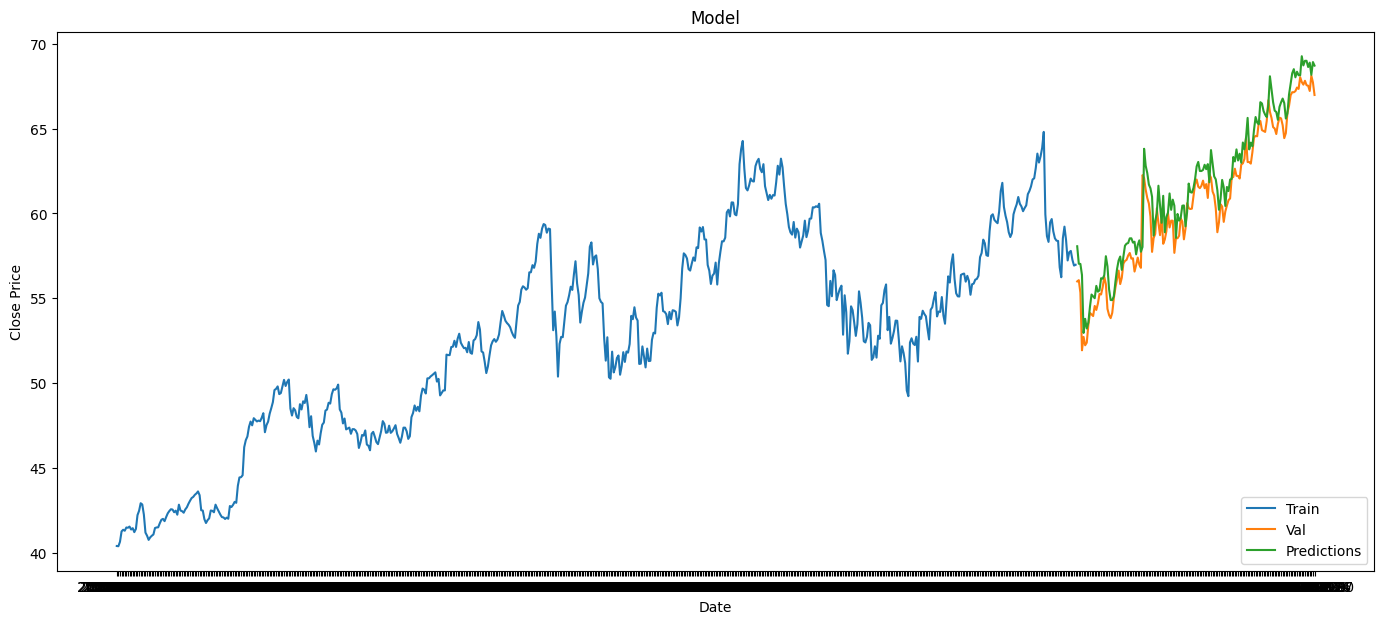

In [ ]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(17,7))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

---------------------------------------------------------------------------

In [ ]:
tweet_df['Polarity'] = results['hid_state'].apply(lambda x: x.numpy())

In [ ]:
dates = pd.DataFrame(stock_data.index)

In [ ]:
dates['Date'] = dates['Date'].apply(lambda date: date.date())

In [ ]:
tweet_df['day_date'] = tweet_df['day_date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d').date())

In [ ]:
tweet_df['day_date'] = tweet_df['day_date'].apply(lambda data: datetime(2000, 1, 1) if (dates['Date']==data).any() == False else data)

/usr/local/lib/python3.9/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [ ]:
pol_df = pd.DataFrame()
pol_df['Date'] = tweet_df['day_date']
pol_df['Polarity'] = tweet_df['Polarity']
pol_df = pol_df[(pol_df['Date'] >= '2017-01-01')]

In [ ]:
stock_data['Polarity'] = 0
stock_data['sum'] = 0

In [ ]:
stock_data['Polarity'] = stock_data['Polarity'].apply(lambda x: np.zeros((1, 768)))

In [ ]:
for index, row in pol_df.iterrows():
    print(row["Polarity"])
    stock_data.at[str(row["Date"].date()), "Polarity"] += row["Polarity"] 
    stock_data.at[str(row["Date"].date()), "sum"] += 1
    print(stock_data.loc[str(row["Date"].date())]["Polarity"], row["Date"])

stock_data

In [ ]:
for index, row in pol_df.iterrows():
    # print(index)
    if str(row["Date"].date()) >= '2019-09-10': 
      # print(index)
      stock_data.at[str(row["Date"].date()), "Polarity"] += row["Polarity"] 
      stock_data.at[str(row["Date"].date()), "sum"] += 1

stock_data

In [ ]:
stock_data["sum"].unique()

array([ 78,  91, 130, 102, 104, 103,  95, 108,  88,  94, 132,  96,  74,
       143, 134, 127, 284, 250, 148, 131, 110, 122, 121, 141,  99, 105,
        98,  92, 123,  82,  51,  58,  53,  47,  46,  75,  68,  61,  56,
        60,  65,  54,  49,  48,  59,  77,  70,  50,  73,  72,  64,  62,
        52,  44,  42,  55,  57,  93, 204,  80,  63,  67,  84,  69,  89,
        87,  71, 113,  79,  66, 182, 106, 254, 242, 116,  83,  81,  86,
        41,  90,  76, 109, 112,  85, 193, 219, 100,  43, 198, 138, 114,
       137, 136, 107, 244, 139, 129,  45, 115, 261, 255, 135, 117, 111,
       206, 180,  38, 101,  37, 271, 225, 146, 289, 320, 234, 128,  39,
       209,  34, 151,  23,  40,  36])

In [ ]:
stock_data["sum"] = stock_data["sum"].apply(lambda x: 1 if x == 0 else x)

In [ ]:
stock_data["Polarity"] = stock_data["Polarity"] / stock_data["sum"]

In [ ]:
stock_data.to_csv(r'/content/gdrive/MyDrive/project/fin_roberta_stock_data_emb0.csv')

In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Polarity,sum
Date,,,,,,,,
2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000,"[0.09324871, 0.04970449, -0.3280555, -0.576182...",78
2017-01-04,40.494499,40.671501,40.205502,40.388500,40.388500,30306000,"[0.12853672, -0.002742749, -0.30984774, -0.573...",91
2017-01-05,40.375000,40.687000,40.296001,40.651001,40.651001,26810000,"[0.12299565, 0.0017796864, -0.2926947, -0.5893...",130
2017-01-06,40.749500,41.448002,40.575001,41.260502,41.260502,40342000,"[0.07996491, 0.021019774, -0.2969147, -0.56027...",102
2017-01-09,41.318501,41.521500,41.081001,41.359001,41.359001,28178000,"[0.15384461, -0.015547115, -0.3020572, -0.5519...",104
...,...,...,...,...,...,...,...,...
2019-12-23,67.936501,68.092499,67.400002,67.531502,67.531502,19936000,"[0.05125317, 0.04173123, -0.22811589, -0.55019...",36
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.221497,13468000,"[0.15515475, 0.05843154, -0.22844082, -0.35465...",40
2019-12-26,67.327499,68.160004,67.275497,68.123497,68.123497,23662000,"[0.057956975, -0.13206616, -0.22089411, -0.508...",57


In [ ]:
stock_data['Polarity'] = stock_data['Polarity'].apply(lambda x: x.numpy())

In [ ]:
emb_data = pd.DataFrame()

In [ ]:
for index, row in stock_data.iterrows():
  emb_data = pd.concat([emb_data, pd.DataFrame(stock_data.at[index,'Polarity']).T], ignore_index=True)
  print(index)

In [ ]:
pd.concat([stock_data, emb_data], axis=1)

In [ ]:
# emb_data.to_csv(r'/content/gdrive/MyDrive/project/fin_roberta_stock_data_emb_data0.csv')

In [ ]:
emb_data_new = pd.read_csv("/content/gdrive/MyDrive/project/fin_roberta_stock_data_emb_data0.csv")

In [ ]:
emb_data_new = emb_data_new.drop('Unnamed: 0', axis=1)

In [ ]:
emb_data = pd.concat([pd.DataFrame(stock_data.index), emb_data_new], axis=1, ignore_index=True)

In [ ]:
emb_data = emb_data.set_index(0)

In [ ]:
emb_data

,1,2,3,4,5,6,7,8,9,10,...,759,760,761,762,763,764,765,766,767,768
0,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.093249,0.049704,-0.328055,-0.576183,0.350670,0.752025,-0.210187,-0.963805,0.185715,-0.261780,...,-0.229229,0.344061,-0.088858,0.465249,0.593343,0.156254,1.530559,-0.670544,-0.298593,0.309176
2017-01-04,0.128537,-0.002743,-0.309848,-0.573030,0.349717,0.696638,-0.171986,-0.935696,0.094132,-0.313677,...,-0.218401,0.315025,-0.019472,0.433092,0.605448,0.141365,1.441515,-0.735410,-0.316620,0.269340
2017-01-05,0.122996,0.001780,-0.292695,-0.589386,0.406685,0.684896,-0.199466,-0.974529,0.170116,-0.336651,...,-0.221232,0.343848,-0.070757,0.400687,0.594680,0.209395,1.430552,-0.679715,-0.285996,0.297259
2017-01-06,0.079965,0.021020,-0.296915,-0.560274,0.446693,0.639473,-0.201527,-0.931554,0.223417,-0.272853,...,-0.186951,0.358163,-0.034621,0.394362,0.597417,0.165760,1.404918,-0.686607,-0.332103,0.319356
2017-01-09,0.153845,-0.015547,-0.302057,-0.551924,0.335348,0.786668,-0.205935,-0.992560,0.117046,-0.312458,...,-0.172999,0.375478,-0.036504,0.451195,0.616102,0.149043,1.420996,-0.709848,-0.334642,0.291304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.051253,0.041731,-0.228116,-0.550193,0.580775,0.529151,-0.265880,-0.896704,0.344340,-0.110789,...,-0.197109,0.289318,0.011702,0.470774,0.653960,0.216481,1.267520,-0.726284,-0.373606,0.285217
2019-12-24,0.155155,0.058432,-0.228441,-0.354659,0.351637,0.627064,-0.289067,-0.858641,0.235530,-0.138461,...,-0.129504,0.200387,0.166588,0.459602,0.689203,0.092795,1.243397,-0.957979,-0.369365,0.322404
2019-12-26,0.057957,-0.132066,-0.220894,-0.508902,0.404115,0.426851,-0.257201,-0.751783,0.266928,-0.140293,...,-0.086072,0.187628,0.166552,0.407893,0.518701,0.087141,1.139652,-0.967701,-0.355483,0.133448


In [ ]:
# stock_data.to_csv(r'/content/gdrive/MyDrive/project/fin_roberta_stock_data_emb_data_withstock_0.csv')

In [ ]:
pd.read_csv("/content/gdrive/MyDrive/project/fin_roberta_stock_data_emb_data_withstock_0.csv", index_col=0)

In [ ]:
stock_data = pd.concat([stock_data, emb_data], axis=1)

In [ ]:
stock_emd_data = stock_data.copy()

In [ ]:
close_prices = stock_data["Close"]
polarity = stock_data[range(1, 769)]
polarity = polarity.values.reshape(-1,768)

values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)
# нормализация
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

scaled_data = np.hstack([scaled_data, polarity])

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 0])
    

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 769))

In [ ]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 769))

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=False, input_shape=(x_train.shape[1], 769)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 100)               348000    
                                                                 
 dense_21 (Dense)            (None, 1)                 101       
                                                                 
Total params: 348,101
Trainable params: 348,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=15)

Epoch 1/15
543/543 [==============================] - 4s 5ms/step - loss: 0.0430
Epoch 2/15
543/543 [==============================] - 3s 6ms/step - loss: 0.0203
Epoch 3/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0178
Epoch 4/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0163
Epoch 5/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0163
Epoch 6/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0131
Epoch 7/15
543/543 [==============================] - 3s 5ms/step - loss: 0.0131
Epoch 8/15
543/543 [==============================] - 3s 6ms/step - loss: 0.0122
Epoch 9/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0101
Epoch 10/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0098
Epoch 11/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0090
Epoch 12/15
543/543 [==============================] - 2s 4ms/step - loss: 0.0070
Epoch 13/15
543/543 [====

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5/5 [==============================] - 0s 5ms/step


1.6819935353597004

In [ ]:
mape = mean_absolute_percentage_error(y_test, predictions)
mape

0.038744506728053636

In [ ]:
r2_score = sklearn.metrics.r2_score(y_test, predictions)
r2_score

0.5498318578000008

<ipython-input-487-8940a43030e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


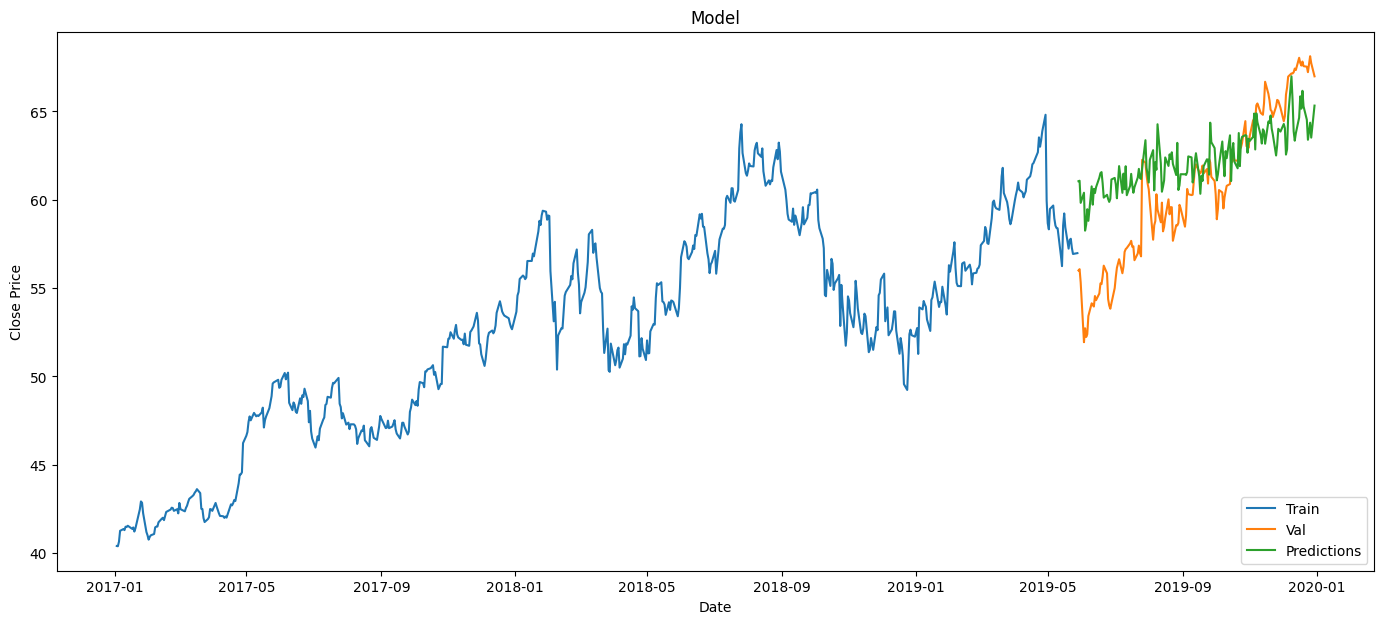

In [ ]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(17,7))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()